In [1]:
import os
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
from chessutils import find_coeffs
from boardgen import chessboard

In [3]:
from clusterization import clusterize

In [4]:
def intersect(i1, i2):
    return (i2[0] <= i1[1]) and (i1[0] <= i2[1])
def closeintervals(i1, i2):
    return intersect(i1, i2) and (abs(i1[2]-i2[2]) == 1)

def centerofmass(c):
    xm = 0
    ym = 0
    nm = 0
    for i in c:
        ns = i[1]-i[0]+1
        xm += 0.5*(i[1]+i[0])*ns
        ym += i[2]*ns
        nm += ns
    return xm/nm, ym/nm

In [5]:
PATH_TO_IMG = 'img'

In [6]:
IMGSIZE = 480
MAXSHEAR = 0.15
MINSCALE = 0.5
NC = 5

HFIMGSIZE = IMGSIZE // 2

In [7]:
def xcrosscorr(bd):
    cftbd = np.fft.fft2(bd)

    cross = np.real(np.fft.ifft2(np.conj(cftbd)*cftbd))
    xross = np.zeros((IMGSIZE,IMGSIZE))

    for i in range(IMGSIZE*IMGSIZE):
        x = i % IMGSIZE
        y = i // IMGSIZE
        xs = (x - HFIMGSIZE) % IMGSIZE
        ys = (y - HFIMGSIZE) % IMGSIZE
        xross[y,x] = cross[ys,xs]
    return xross

In [8]:
figimgs = [f for f in os.listdir(PATH_TO_IMG) if f.split('_')[0]=='Chess']
figuresimgs = dict()
for f in figimgs:
    fn = f.split('_')[1].split('4')[0]
    img = cv2.imread(os.path.join(PATH_TO_IMG, f))
    figuresimgs[fn] = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

figs = ['p', 'b', 'n', 'r', 'q', 'k']
colors = ['d', 'l']

In [9]:
parameters = {
    'numcell':8,
    'cellsize':45,
    'figures':figs,
    'colors':colors,
    'shear':MAXSHEAR,
    'scale':MINSCALE,
}

In [10]:
def randomboardpoints(nc, params):
    boardsize = params['cellsize'] * params['numcell']
    mask = 255*np.ones((boardsize,boardsize), np.uint8)
    nb = params['numcell']*params['numcell']
    npt = np.random.randint(1,nc+1,size=nb)
    nzz = np.random.randint(nb, size=2)
    npt[nzz] = 0
    for i in range(nb):
        xp = i % params['numcell']
        yp = i // params['numcell']
        sz = npt[i]
        if (xp != 0) and (yp != 0) and sz > 0:
            mask[yp*params['cellsize']-sz:yp*params['cellsize']+sz,xp*params['cellsize']-sz:xp*params['cellsize']+sz] = 0
    return mask

In [11]:
def boardmask(imgsize):
    boardimage, _, vecs = chessboard(figuresimgs, np.random.rand(13), imgsize, parameters)
    blank_mask = randomboardpoints(NC, parameters)

    img = Image.fromarray(blank_mask, 'L')
    coeffs = find_coeffs(
         vecs.reshape((4,2)),
         [(0, 0), (blank_mask.shape[1], 0), (blank_mask.shape[1], blank_mask.shape[0]), (0, blank_mask.shape[0])])

    img = img.transform((imgsize, imgsize), Image.PERSPECTIVE, coeffs, Image.NEAREST, fillcolor = 'white')
    return 1-np.asarray(img)/255

In [12]:
def addpoints(img, num):
    xyadd = np.random.rand(num,3)
    for i in range(num):
        xc = int(img.shape[1]*xyadd[i,0])
        yc = int(img.shape[0]*xyadd[i,1])
        nc = int(NC*xyadd[i,2])+1
        img[yc-nc:yc+nc,xc-nc:xc+nc] = 1
    return

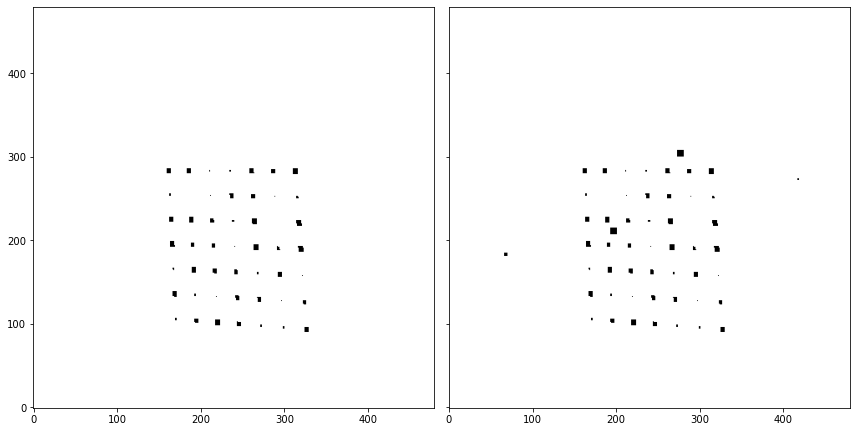

In [13]:
bd = boardmask(IMGSIZE)

fig, axxes = plt.subplots(ncols=2, nrows=1, figsize=(12,6), sharex=True, sharey=True)
axxes[0].imshow(1-bd, cmap='gray', origin='lower')
addpoints(bd, 4)
axxes[1].imshow(1-bd, cmap='gray', origin='lower')
fig.tight_layout()
plt.show()

In [14]:
#Clusterizing points
xsumms = np.sum(bd, axis=-1)
res = []
for y, xsumm in enumerate(xsumms):
    if xsumm == 0:
        continue
    ##TODO extend with zeros??
    s = bd[y]
    diffs = s[1:]-s[:-1]
    starts = np.where(diffs==1)[0]
    ends = np.where(diffs==-1)[0]
    for i1, i2 in zip(starts,ends):
        res.append([i1+1,i2,y])
cl = clusterize(res, closeintervals)

In [15]:
len(cl)

51

In [16]:
#Centers of clusters
xy = np.array(list(map(centerofmass, cl)))
xy.shape

(51, 2)

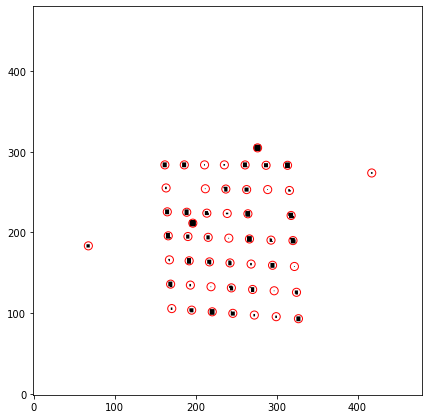

In [17]:
fig, axxes = plt.subplots(ncols=1, nrows=1, figsize=(6,6), sharex=True, sharey=True)
axxes.imshow(1-bd, cmap='gray', origin='lower')
for t in xy:
    axxes.add_patch(plt.Circle((t[0], t[1]), 5, color='r', fill=False))
fig.tight_layout()
plt.show()

In [165]:
bd.shape

(480, 480)

In [168]:
def detectshifts(bd):
    xc = xcrosscorr(bd)
    imgsize = bd.shape[0]
    hfimgsize = imgsize // 2
    xp1 = np.zeros_like(xc)
    xp2 = np.zeros_like(xc)
    xp1[:,hfimgsize-10:hfimgsize+10] = xc[:,hfimgsize-10:hfimgsize+10]
    xp1[hfimgsize-10:hfimgsize+10,:] = 0
    xp2[hfimgsize-10:hfimgsize+10,:] = xc[hfimgsize-10:hfimgsize+10,:]
    xp2[:,hfimgsize-10:hfimgsize+10] = 0

    p1 = np.argmax(xp1)
    p2 = np.argmax(xp2)
    yshift = np.array([p1 % imgsize - hfimgsize, p1 // imgsize - hfimgsize])
    xshift = np.array([p2 % imgsize - hfimgsize, p2 // imgsize - hfimgsize])
    
    if xshift[0] < 0:
        xshift *= -1
    if yshift[1] < 0:
        yshift *= -1
    return xshift, yshift

In [169]:
detectshifts(bd)

(array([25, -1]), array([-2, 31]))

In [32]:
def mhdist(x, y):
    return np.sum(np.abs(np.array(x)-np.array(y)))

In [163]:
vect = np.array([xshift,yshift])
abdir = np.vstack((np.eye(2, dtype=int),-np.eye(2, dtype=int)))

In [164]:
def detectnei(purecl, start=0):
    visited = np.zeros(len(purecl)).astype(bool)
    ixysites = np.zeros((len(purecl),2), dtype=int)
    checked = np.zeros(len(purecl)).astype(bool)
    visited[start] = True

    while (np.sum(visited) < len(purecl)):
        nvisited = np.sum(visited)
        for ns in range(len(purecl)):

            if checked[ns]:
                continue
            if not(visited[ns]):
                continue
            p = purecl[ns]

            for ab in abdir:
                pxy = p + np.dot(ab, vect)
                xyd = {i:mhdist(c,pxy) for i,c in enumerate(purecl)}
                xydm = min(xyd, key=xyd.get)
                xydm, xyd[xydm]
                if (xyd[xydm] < 10):
                    visited[xydm] = True
                    ixysites[xydm] = ixysites[ns] + ab
            checked[ns] = True
        if (np.sum(visited) == nvisited):
            break
            
    return purecl[visited], ixysites[visited]

In [162]:
detectnei(xy, 8)

(array([[327.        ,  93.5       ],
        [299.5       ,  96.        ],
        [272.5       ,  98.        ],
        [245.92307692, 100.11538462],
        [220.5       , 102.        ],
        [195.08333333, 104.08333333],
        [170.5       , 106.        ],
        [324.57894737, 126.10526316],
        [270.4       , 129.6       ],
        [297.        , 128.        ],
        [244.15384615, 131.57692308],
        [169.09090909, 136.18181818],
        [219.        , 133.        ],
        [193.5       , 135.        ],
        [295.        , 159.5       ],
        [322.        , 158.        ],
        [242.43478261, 162.39130435],
        [268.5       , 161.        ],
        [217.10714286, 163.67857143],
        [192.        , 165.        ],
        [167.6       , 166.2       ],
        [320.21428571, 190.        ],
        [266.5       , 192.        ],
        [293.07142857, 190.57142857],
        [215.5       , 194.        ],
        [166.16216216, 195.86486486],
        [190

In [150]:
minc = np.min(ixysites[visited], axis=0)
maxc = np.max(ixysites[visited], axis=0)

In [151]:
minc, maxc

(array([-6,  0]), array([0, 6]))

In [152]:
np.where(ixysites[visited][:,0] == -6)[0]

array([ 6, 11, 20, 25, 32, 38, 41])

In [153]:
np.where(ixysites[visited][:,0] == 0)[0]

array([ 0,  7, 15, 21, 28, 36, 40])

In [154]:
np.where(ixysites[visited][:,1] == 0)[0]

array([0, 1, 2, 3, 4, 5, 6])

In [155]:
np.where(ixysites[visited][:,1] == 6)[0]

array([40, 41, 42, 43, 44, 45, 46])

In [157]:
xy[visited][_155]

array([[313.5       , 283.        ],
       [162.        , 283.5       ],
       [186.        , 283.5       ],
       [261.09677419, 283.41935484],
       [287.        , 283.        ],
       [211.        , 283.5       ],
       [235.5       , 283.5       ]])

In [134]:
ixysites[visited][:,1] == 1

array([False,  True, False,  True, False,  True, False,  True, False,
        True, False,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False])

In [137]:
np.logical_and(ixysites[visited][:,0] == -5, ixysites[visited][:,1] == 1)

array([False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False])

In [139]:
np.where(ixysites[visited] == [-5,1])

(array([ 1,  3,  5,  7,  9, 10, 11, 12, 12, 13, 15, 40, 41, 42]),
 array([1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0]))

In [34]:
a1c, a1p = findcorner([0,-1], [-1,0])
h8c, h8p = findcorner([0,1], [1,0])
a8c, a8p = findcorner([0,1], [-1,0])
h1c, h1p = findcorner([0,-1], [1,0])

In [35]:
h1c-a1c, h8c-a8c

(array([6, 0]), array([6, 0]))

In [36]:
h8c-h1c, a8c-a1c

(array([0, 6]), array([0, 6]))

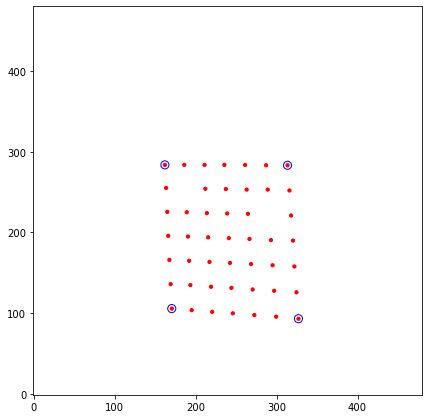

In [39]:
fig, axxes = plt.subplots(ncols=1, nrows=1, figsize=(6,6), sharex=True, sharey=True)
axxes.imshow(np.ones((IMGSIZE,IMGSIZE)), cmap='gray', origin='lower', vmin=0, vmax=1)
for t in purecl:
    axxes.add_patch(plt.Circle((t[0], t[1]), 2, color='r'))
for u in [a1p,a8p,h1p,h8p]:
    t = purecl[u]
    axxes.add_patch(plt.Circle((t[0], t[1]), 5, color='b', fill=False))
fig.tight_layout()
plt.show()